In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('icd_similarity_sample.csv')

In [ ]:
df

In [ ]:
grouped = df.groupby(['patient_sk', 'admit_dt_tm'])['diagnosis'].apply(list).reset_index()
sequences = grouped['diagnosis'].tolist()

all_codes = sorted(set(str(code) for seq in sequences for code in seq if pd.notna(code)))

vocab = {code: i+1 for i, code in enumerate(all_codes)}  # 0 - PAD
vocab['[PAD]'] = 0
vocab['[MASK]'] = len(vocab)
inv_vocab = {i: code for code, i in vocab.items()}
vocab_size = len(vocab)

from sklearn.model_selection import train_test_split
train_seqs, val_seqs = train_test_split(sequences, test_size=0.2, random_state=42)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import random

class MaskedICDDataset(Dataset):
    def __init__(self, sequences, vocab, mask_prob=0.15, max_len=50):
        self.sequences = sequences
        self.vocab = vocab
        self.mask_prob = mask_prob
        self.max_len = max_len

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx][:self.max_len]
        token_ids = [self.vocab.get(code, self.vocab['[PAD]']) for code in seq]
        labels = [-100] * len(token_ids)

        for i in range(len(token_ids)):
            if random.random() < self.mask_prob:
                labels[i] = token_ids[i]
                prob = random.random()
                if prob < 0.8:
                    token_ids[i] = self.vocab['[MASK]']
                elif prob < 0.9:
                    token_ids[i] = random.randint(1, len(self.vocab) - 2)
                # else: leave unchanged

        while len(token_ids) < self.max_len:
            token_ids.append(self.vocab['[PAD]'])
            labels.append(-100)

        return torch.tensor(token_ids), torch.tensor(labels)

train_dataset = MaskedICDDataset(train_seqs, vocab)
val_dataset = MaskedICDDataset(val_seqs, vocab)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
import torch.nn as nn
class TinyICDBERT(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hidden_dim=256):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=4)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.linear = nn.Linear(emb_dim, vocab_size)

    def forward(self, x):
        x = self.emb(x)              # [B, L, D]
        x = x.transpose(0, 1)        # [L, B, D]
        x = self.encoder(x)          # [L, B, D]
        x = x.transpose(0, 1)        # [B, L, D]
        return self.linear(x)        # [B, L, vocab_size]

model = TinyICDBERT(vocab_size).to('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torch.optim as optim
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_epochs = 40
batch_size = 64
embed_path = 'icd_input_embeddings.pt'
dist_path  = 'icd_cosine_distances.pt'

model = model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss(ignore_index=-100)

history = {'epoch': [], 'train_loss': [], 'val_loss': [], 'val_acc': []}

In [ ]:
for epoch in range(n_epochs):
    model.train()
    total_train_loss = 0
    for tokens, labels in tqdm(train_loader, desc=f'Train Epoch {epoch+1}'):
        tokens, labels = tokens.to(device), labels.to(device)
        logits = model(tokens)
        loss = criterion(logits.view(-1, vocab_size), labels.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    model.eval()
    total_val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for tokens, labels in val_loader:
            tokens, labels = tokens.to(device), labels.to(device)
            logits = model(tokens)
            loss = criterion(logits.view(-1, vocab_size), labels.view(-1))
            total_val_loss += loss.item()
            preds = torch.argmax(logits, dim=-1)
            mask = (labels != -100)
            correct += (preds[mask] == labels[mask]).sum().item()
            total += mask.sum().item()

    val_acc = 100 * correct / total
    history['epoch'].append(epoch+1)
    history['train_loss'].append(total_train_loss / len(train_loader))
    history['val_loss'].append(total_val_loss / len(val_loader))
    history['val_acc'].append(val_acc)
    print(f'Epoch {epoch+1}: Train Loss = {total_train_loss/len(train_loader):.4f}, '
          f'Val Loss = {total_val_loss/len(val_loader):.4f}, Val Acc = {val_acc:.2f}%')

In [ ]:
model.eval()
emb_matrix = model.get_input_embeddings().weight.data.cpu()  # [vocab_size, embed_dim]
torch.save(emb_matrix, embed_path)
print(f"Saved input embeddings to {embed_path}")

In [ ]:
# cos_sim = dot(u,v)
normed = emb_matrix / emb_matrix.norm(dim=1, keepdim=True)  # [vocab_size, embed_dim]
# cos_sim matrix
cos_sim = torch.mm(normed, normed.t())                        # [vocab_size, vocab_size]
# cos_dist = 1 - cos_sim
cos_dist = 1.0 - cos_sim
torch.save(cos_dist, dist_path)
print(f"Saved cosine distance matrix to {dist_path}")

In [ ]:
emb_matrix = model.emb.weight.data.cpu()  # [vocab_size, emb_dim]
torch.save(emb_matrix, 'tinybert_input_embeddings.pt')

normed = emb_matrix / emb_matrix.norm(dim=1, keepdim=True)

cos_sim  = torch.mm(normed, normed.t())      # [vocab_size, vocab_size]
cos_dist = 1.0 - cos_sim
torch.save(cos_dist, 'tinybert_cosine_distances.pt')


In [ ]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.plot(history['epoch'], history['train_loss'], label='Train Loss', color='red')
ax1.plot(history['epoch'], history['val_loss'], label='Val Loss', color='orange')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2 = ax1.twinx()
ax2.plot(history['epoch'], history['val_acc'], label='Val Accuracy', color='blue')
ax2.set_ylabel('Accuracy (%)')
fig.legend(loc='upper right')
plt.title('Training/Validation Loss and Accuracy')
plt.tight_layout()
plt.show()


In [ ]:
sim_df.to_csv('icd_similarity_sample.csv')

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

with torch.no_grad():
    emb_matrix = model.emb.weight.cpu().numpy()
    codes = [code for code, idx in sorted(vocab.items(), key=lambda x: x[1])]
    sim_matrix = cosine_similarity(emb_matrix)
    sim_df = pd.DataFrame(sim_matrix, index=codes, columns=codes)


In [ ]:
sim_df

In [ ]:
target_codes = ['Z91', 'J35', 'J30', 'K86', 'H20']

present_codes = [code for code in target_codes if code in sim_df.index]

for code in present_codes:
    print(f"\nTop correlations for {code}:")
    sorted_similarities = sim_df.loc[code].sort_values(ascending=False)
    print(sorted_similarities.head(10))

In [ ]:
target_codes = ['Z91', 'J35', 'J30', 'K86', 'H20']

short_codes = [code[:3] for code in target_codes]

results = []

for code in short_codes:
    if code in sim_df.index:
        top_similar = sim_df.loc[code].drop(code).sort_values(ascending=False).head(20)
        for similar_code, similarity in top_similar.items():
            results.append({
                'Target': code,
                'Most Similar': similar_code,
                'Similarity': similarity
            })

similar_df = pd.DataFrame(results)

print(similar_df)


In [ ]:
similar_df.to_csv('icd_similarity.csv')

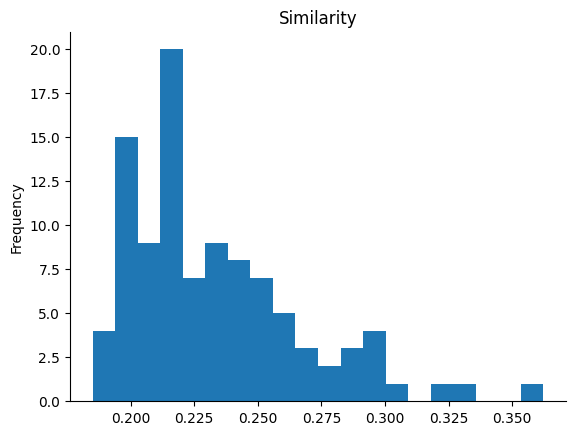

In [ ]:
from matplotlib import pyplot as plt
similar_df['Similarity'].plot(kind='hist', bins=20, title='Similarity')
plt.gca().spines[['top', 'right',]].set_visible(False)

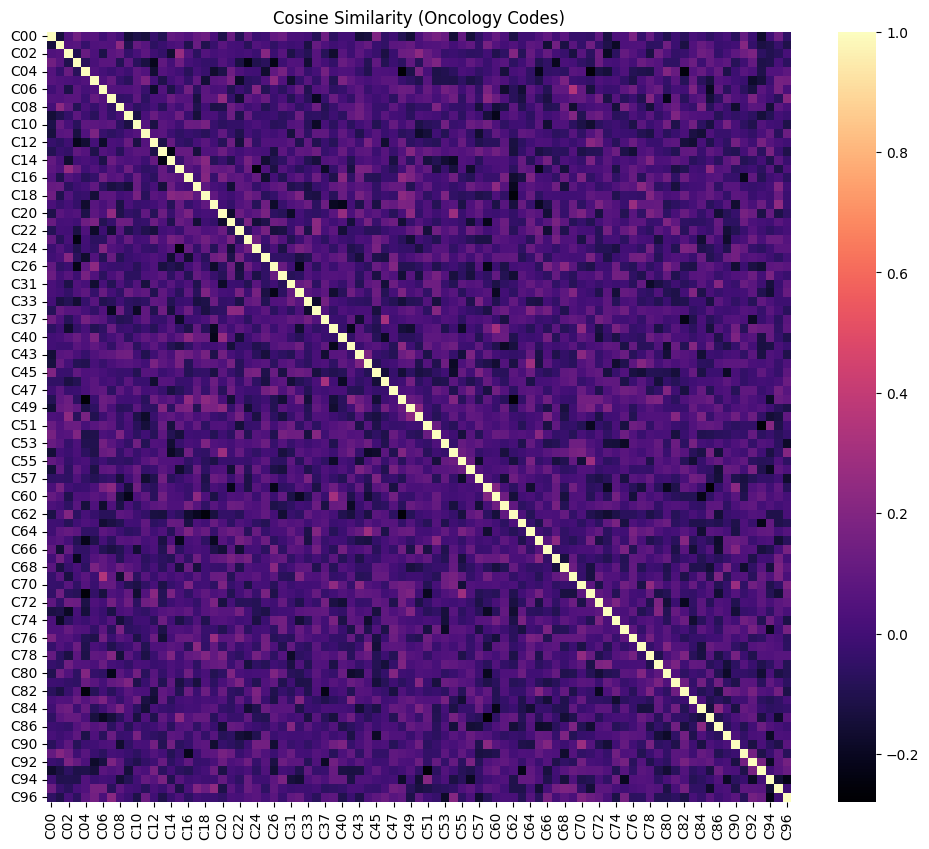

In [ ]:
oncology_codes = [code for code in codes if code.startswith('C') and code[1:3].isdigit() and 0 <= int(code[1:3]) <= 97]
onco_df = sim_df.loc[oncology_codes, oncology_codes]
plt.figure(figsize=(12, 10))
sns.heatmap(onco_df, cmap='magma')
plt.title('Cosine Similarity (Oncology Codes)')
plt.show()


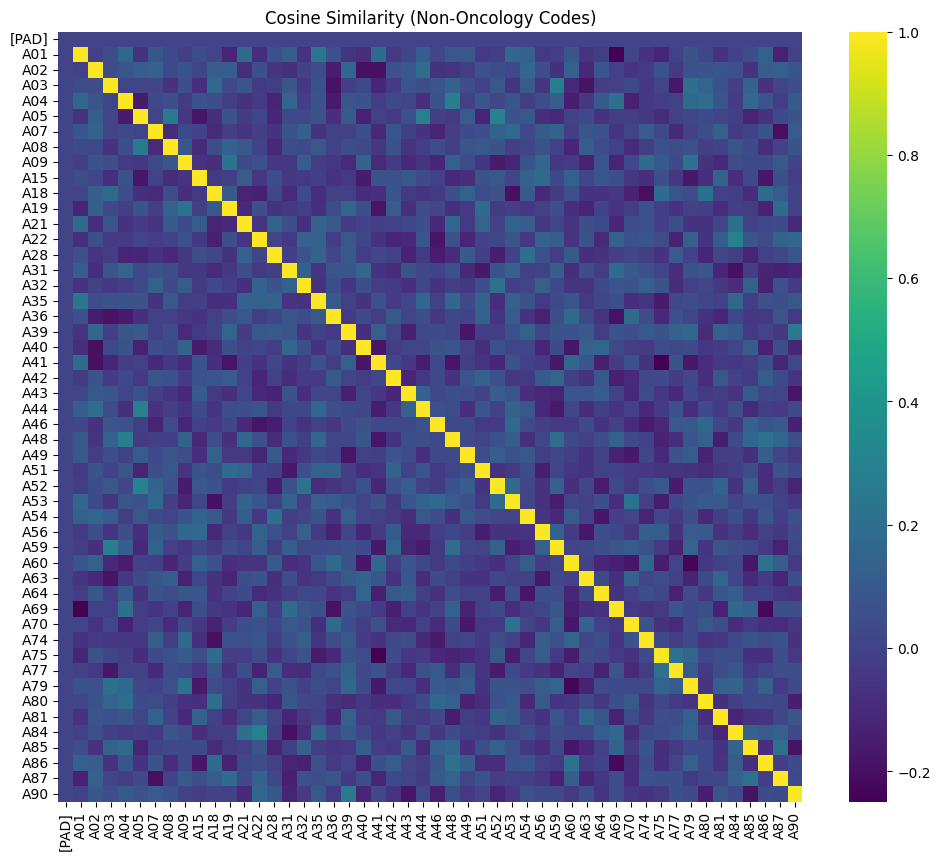

In [ ]:
non_onco_codes = [c for c in codes if not c.startswith('C')][:50]
non_df = sim_df.loc[non_onco_codes, non_onco_codes]
plt.figure(figsize=(12, 10))
sns.heatmap(non_df, cmap='viridis')
plt.title('Cosine Similarity (Non-Oncology Codes)')
plt.show()

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
coords = tsne.fit_transform(emb_matrix)
plt.figure(figsize=(10, 10))
plt.scatter(coords[:, 0], coords[:, 1], alpha=0.6, s=10)
for i, code in enumerate(codes[:1000]):
    plt.text(coords[i, 0], coords[i, 1], code, fontsize=6)
plt.title('t-SNE projection of ICD code embeddings')
plt.grid(True)
plt.show()


In [ ]:

mask = (labels != -100)

masked_preds = preds[mask]
masked_labels = labels[mask]

pred_emb = model.emb(masked_preds)
true_emb = model.emb(masked_labels)

cos_sim = cosine_similarity(pred_emb, true_emb, dim=-1)
total_cos_sim += cos_sim.sum().item()
total_masked += mask.sum().item()


In [ ]:
from torch.nn.functional import cosine_similarity

model.eval()
total_cos_sim = 0
total_masked = 0

with torch.no_grad():
    for tokens, labels in val_loader:
        tokens, labels = tokens.to(device), labels.to(device)

        logits = model(tokens)
        preds = torch.argmax(logits, dim=-1)


        mask = (labels != -100)


        pred_emb = model.emb(preds)[mask]
        true_emb = model.emb(labels)[mask]

        cos_sim = cosine_similarity(pred_emb, true_emb, dim=-1)
        total_cos_sim += cos_sim.sum().item()
        total_masked += mask.sum().item()

avg_cos_sim = total_cos_sim / total_masked
print(f'Average cosine similarity (val): {avg_cos_sim:.4f}')


In [ ]:
import numpy as np
from statsmodels.stats.multitest import fdrcorrection

In [ ]:
distance_df = pd.read_csv('/content/icd_similarity_sample.csv', index_col=0)
cancer_codes_df = pd.read_excel('/content/cancer_icd3_codes.xlsx')

print(cancer_codes_df.columns)  # ← Посмотри, как называется столбец!
cancer_codes = cancer_codes_df.iloc[:, 0].astype(str).str.strip().tolist()

cancer_codes = [code for code in cancer_codes if code in distance_df.index]

cancer_vs_all = distance_df.loc[cancer_codes, :]

all_distances = distance_df.values[np.triu_indices_from(distance_df, k=1)]
results = []

for cancer in cancer_vs_all.index:
    for disease in cancer_vs_all.columns:
        sim = cancer_vs_all.loc[cancer, disease]

        p_val = np.mean(all_distances >= sim)
        results.append((cancer, disease, sim, p_val))

results_df = pd.DataFrame(results, columns=['Cancer', 'Disease', 'Similarity', 'p_value'])
results_df['p_adj'] = fdrcorrection(results_df['p_value'])[1]
significant = results_df[results_df['p_adj'] < 0.05].sort_values(by='Similarity', ascending=False)

In [ ]:
significant = significant[significant["Cancer"] != significant["Disease"]]

significant = significant[significant["Similarity"] < 1.0]

In [ ]:
import seaborn as sns
top10 = significant.sort_values("Similarity", ascending=False).drop_duplicates(subset=['Cancer', 'Disease']).head(10)
pivot_sparse = top10.pivot(index='Cancer', columns='Disease', values='Similarity')

plt.figure(figsize=(8, 6))
ax = sns.heatmap(pivot_sparse, annot=True, fmt=".2f", cmap="rocket", vmin=0, vmax=1, cbar=True, linewidths=0.5, linecolor='gray', square=True)

plt.title("Top 8 oncology→diseases by similarity (MLM)", fontsize=14)
plt.xlabel("Disease")
plt.ylabel("Cancer")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
icd_descriptions = {
    "C00": "Malignant neoplasm of lip",
    "C16": "Malignant neoplasm of stomach",
    "C20": "Malignant neoplasm of rectum",
    "C38": "Malignant neoplasm of heart, mediastinum and pleura",
    "C67": "Malignant neoplasm of bladder",
    "C85": "Non-Hodgkin lymphoma (other & unspecified types)",
    "C96": "Malignant neoplasm of lymphoid, hematopoietic and related tissue",
    "D48": "Neoplasm of uncertain/unknown behavior",
    "E77": "Disorders of glycoprotein metabolism",
    "K41": "Inguinal hernia",
    "N99": "Postprocedural genitourinary disorders",
    "V17": "Family history of disabling diseases"
}

# Добавим колонку с красивыми подписями
df = significant.drop_duplicates(subset=["Similarity"])  # Чтобы убрать дубли
df["Pair"] = df.apply(
    lambda row: f"{row['Cancer']} ({icd_descriptions.get(row['Cancer'], row['Cancer'])}) - "
                f"{row['Disease']} ({icd_descriptions.get(row['Disease'], row['Disease'])})",
    axis=1
)


In [ ]:
df_sorted = df.sort_values("Similarity", ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(data=df_sorted, y="Pair", x="Similarity", palette="rocket", orient='h')

plt.xlabel("MLM-estimated similarity", fontsize=12)
plt.ylabel("ICD pair (with descriptions)", fontsize=12)
plt.title("Top cancer-related disease pairs", fontsize=14)
plt.xlim(0, 0,5)
plt.tight_layout()
plt.show()


In [ ]:
cancer_vs_all = distance_df.loc[cancer_codes, :]

results = []
for cancer_code in cancer_vs_all.index:
    for disease_code in cancer_vs_all.columns:
        if cancer_code != disease_code:
            dist = cancer_vs_all.loc[cancer_code, disease_code]
            results.append((cancer_code, disease_code, dist))

results_df = pd.DataFrame(results, columns=["Cancer", "Disease", "Distance"])

all_distances = distance_df.values
off_diagonal = all_distances[~np.eye(all_distances.shape[0],dtype=bool)].flatten()

results_df["p_value"] = results_df["Distance"].apply(lambda d: np.mean(off_diagonal <= d))

results_df["fdr_corrected"] = multipletests(results_df["p_value"], method="fdr_bh")[1]
results_df["significant"] = results_df["fdr_corrected"] < 0.05

significant_df = results_df[results_df["significant"]]

significant_df["Similarity"] = 1 - significant_df["Distance"]
top10_df = significant_df.sort_values("Similarity", ascending=False).head(10)

heatmap_data = top10_df.pivot(index="Cancer", columns="Disease", values="Similarity")

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, cmap="Reds", linewidths=0.5, fmt=".2f")
plt.title("Heatmap of similarity for top-10 oncology-disease pairs (MLM)")
plt.tight_layout()
plt.show()

In [ ]:
icd_descriptions = {
    'C85': 'Non-Hodgkin lymphoma (other & unspecified types)',
    'C38': 'Malignant neoplasm of heart, mediastinum and pleura',
    'C16': 'Malignant neoplasm of stomach',
    'C20': 'Malignant neoplasm of rectum',
    'C00': 'Malignant neoplasm of lip',
    'K41': 'Inguinal hernia',
    'D48': 'Neoplasm of uncertain/unknown behavior',
    'E77': 'Disorders of glycoprotein metabolism',
    'C96': 'Malignant neoplasm of lymphoid, hematopoietic and related tissue',
    'V17': 'Family history of disabling diseases',
    'C67': 'Malignant neoplasm of bladder',
    'N99': 'Postprocedural genitourinary disorders'
}

data = [
    ('C85', 'C38', 0.396315),
    ('C16', 'C20', 0.366831),
    ('C00', 'K41', 0.365189),
    ('D48', 'E77', 0.363010),
    ('C96', 'V17', 0.360758),
    ('C67', 'N99', 0.355960)
]

df = pd.DataFrame(data, columns=['ICD1', 'ICD2', 'Similarity'])

def make_label(code1, code2):
    label1 = f"{code1} ({icd_descriptions.get(code1, '')})"
    label2 = f"{code2} ({icd_descriptions.get(code2, '')})"
    return f"{label1}\n{label2}"

df['ICD_pair'] = df.apply(lambda row: make_label(row['ICD1'], row['ICD2']), axis=1)

plt.figure(figsize=(10, 5))
sns.set(style="whitegrid")
barplot = sns.barplot(
    x='Similarity',
    y='ICD_pair',
    data=df,
    palette='magma'
)

plt.title('Top cancer-related disease pairs', fontsize=14)
plt.xlabel('MLM-estimated similarity', fontsize=12)
plt.ylabel('ICD pair (code + description)', fontsize=12)

plt.tight_layout()
plt.savefig("top_icd_similarity_plot.pdf", bbox_inches='tight')
plt.show()
